###**Importing Libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [7]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

###**Data Loading and Overview**

In [8]:
df=pd.read_csv("Consumer_Complaints.csv")
df.head()

,product,complaints
0,Credit reporting,I have outdated information on my credit repor...
1,Loan,I purchased a new car on XXXX XXXX. The car de...
2,Credit reporting,An account on my credit report has a mistaken ...
3,Debt collection,This company refuses to provide me verificatio...
4,Debt collection,This complaint is in regards to Square Two Fin...


In [9]:
df.shape

(24374, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24374 entries, 0 to 24373
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product     24374 non-null  object
 1   complaints  24374 non-null  object
dtypes: object(2)
memory usage: 381.0+ KB


###**Data Preprocessing**

####**Data Cleaning**

In [11]:
print("Missing values:\n")
df.isnull().sum()

Missing values:



product       0
complaints    0
dtype: int64

In [12]:
df = df.dropna()

In [13]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


In [14]:
df = df.drop_duplicates()

In [15]:
df.shape

(24374, 2)

#### **Exploratory Data Analysis**

In [16]:
print("Unique Products:", df["product"].unique())

Unique Products: ['Credit reporting' 'Loan' 'Debt collection' 'Mortgage' 'Credit card'
 'Bank account']


In [17]:
product_counts = df['product'].value_counts()
display(product_counts)

product
Debt collection     6169
Mortgage            4932
Credit reporting    4731
Loan                3530
Credit card         2858
Bank account        2154
Name: count, dtype: int64

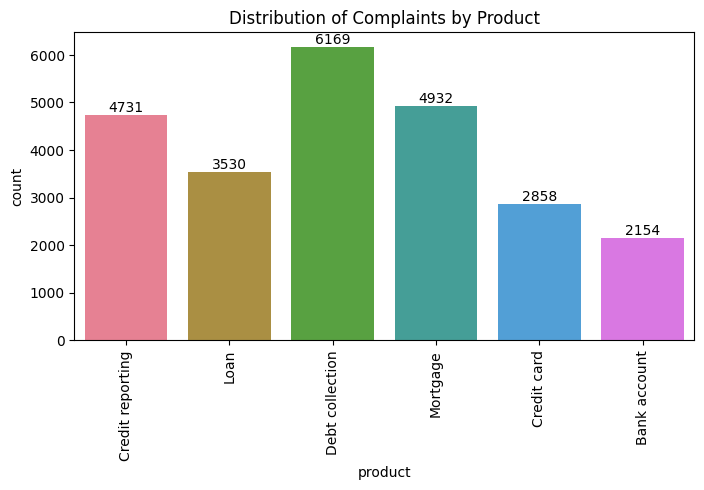

In [18]:
#Plot product distribution
plt.figure(figsize=(8,4))
p = sns.countplot(x='product', data=df,hue='product', palette='husl')
plt.title('Distribution of Complaints by Product')
plt.xticks(rotation=90)

for bars in p.containers:
    p.bar_label(bars, fmt='%d')

plt.show()


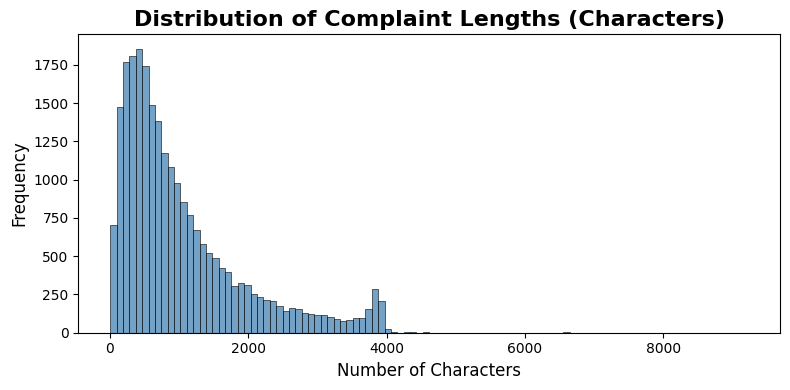

In [19]:
# Calculate complaint length
df['complaint_length'] = df['complaints'].astype(str).str.len()
# Visualize complaint length distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['complaint_length'], bins=100, color='steelblue')
plt.title('Distribution of Complaint Lengths (Characters)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
print("Statistics:")
print(f"Average complaint length: {df['complaint_length'].mean():.0f} characters")
print(f"Median complaint length: {df['complaint_length'].median():.0f} characters")
print(f"Shortest complaint: {df['complaint_length'].min():.0f} characters")
print(f"Longest complaint: {df['complaint_length'].max():.0f} characters")

Statistics:
Average complaint length: 1041 characters
Median complaint length: 741 characters
Shortest complaint: 6 characters
Longest complaint: 9226 characters


#### **Text Preprocessing**

In [21]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Convert to lowercase and handle NaN
    if pd.isna(text) or not str(text).strip():
        return ''
    text = str(text).lower().strip()

    # 2. Remove URLs, emails, special characters, digits, and extra whitespaces
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)                   # Remove email addresses
    text = re.sub(r'[^a-z\s]', '', text)                  # Keep only alphabets and spaces
    text = re.sub(r'\s+', ' ', text).strip()              # Remove extra spaces

    # 3. Tokenize
    words = word_tokenize(text)

    # 4. Remove stopwords
    words = [w for w in words if w not in stop_words]

    # 5. Lemmatize (as verbs)
    words = [lemmatizer.lemmatize(w, pos='v') for w in words]

    # 6. Remove very short words (<=2 letters)
    words = [w for w in words if len(w) > 2]

    # 7. Join tokens back into a cleaned sentence
    return ' '.join(words)


In [22]:
df['cleaned_complaints'] = df['complaints'].apply(clean_text)
df[['complaints', 'cleaned_complaints']].head()

,complaints,cleaned_complaints
0,I have outdated information on my credit repor...,outdated information credit report previously ...
1,I purchased a new car on XXXX XXXX. The car de...,purchase new car xxxx xxxx car dealer call cit...
2,An account on my credit report has a mistaken ...,account credit report mistake date mail debt v...
3,This company refuses to provide me verificatio...,company refuse provide verification validation...
4,This complaint is in regards to Square Two Fin...,complaint regard square two financial refer cf...


####**Label Encoding**

In [23]:
# Encode categorical target (product)
le = LabelEncoder()
df['product_encoded'] = le.fit_transform(df['product'])

In [24]:
df = df.drop(['complaint_length'], axis=1)

In [25]:
df.head()

,product,complaints,cleaned_complaints,product_encoded
0,Credit reporting,I have outdated information on my credit repor...,outdated information credit report previously ...,2
1,Loan,I purchased a new car on XXXX XXXX. The car de...,purchase new car xxxx xxxx car dealer call cit...,4
2,Credit reporting,An account on my credit report has a mistaken ...,account credit report mistake date mail debt v...,2
3,Debt collection,This company refuses to provide me verificatio...,company refuse provide verification validation...,3
4,Debt collection,This complaint is in regards to Square Two Fin...,complaint regard square two financial refer cf...,3


###**Model Implementation and Training**

In [26]:
# Define features and labels
X = df['cleaned_complaints']
y = df['product_encoded']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [28]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")
print(f"Number of features (vocabulary size): {len(tfidf.vocabulary_)}")


Training features shape: (19499, 10000)
Testing features shape: (4875, 10000)
Number of features (vocabulary size): 10000


Before SMOTE: [1723 2286 3785 4935 2824 3946]
After SMOTE: [4935 4935 4935 4935 4935 4935]


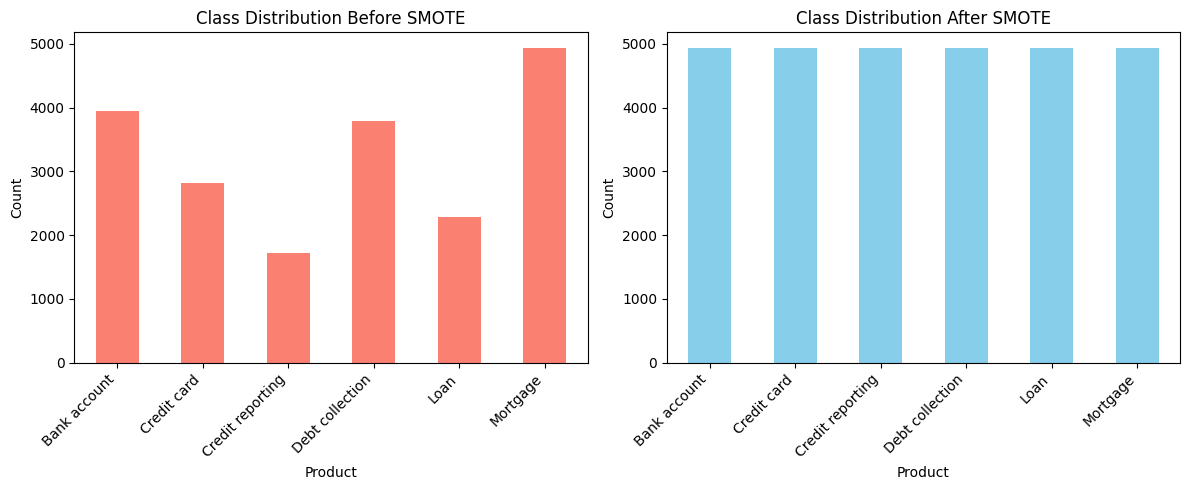

In [29]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Print class counts before and after
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

# Convert y labels to pandas Series with product names
before = pd.Series(y_train).map(dict(enumerate(df['product'].unique()))).value_counts().sort_index()
after = pd.Series(y_train_resampled).map(dict(enumerate(df['product'].unique()))).value_counts().sort_index()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
before.plot(kind='bar', color='salmon')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
after.plot(kind='bar', color='skyblue')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [30]:
print("MODEL 1: LOGISTIC REGRESSION")
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)
y_pred_log = log_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_log))

MODEL 1: LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       431
           1       0.80      0.85      0.82       572
           2       0.85      0.85      0.85       946
           3       0.85      0.85      0.85      1234
           4       0.82      0.81      0.81       706
           5       0.94      0.91      0.93       986

    accuracy                           0.86      4875
   macro avg       0.85      0.85      0.85      4875
weighted avg       0.86      0.86      0.86      4875



In [31]:
print("MODEL 2: SUPPORT VECTOR MACHINE (SVM)")
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm))

MODEL 2: SUPPORT VECTOR MACHINE (SVM)
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       431
           1       0.79      0.82      0.80       572
           2       0.85      0.84      0.84       946
           3       0.83      0.84      0.84      1234
           4       0.82      0.81      0.81       706
           5       0.93      0.92      0.93       986

    accuracy                           0.85      4875
   macro avg       0.84      0.84      0.84      4875
weighted avg       0.85      0.85      0.85      4875



###**Model Comparison and Evaluation**

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.8554,0.8563,0.8554,0.8557
1,Support Vector Machine,0.8480,0.8486,0.8480,0.8482


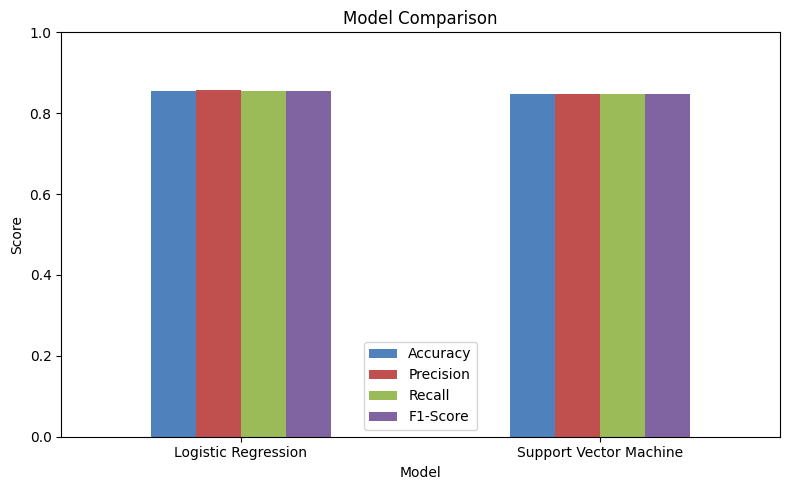

In [34]:
# Compare metrics
models = {
    'Logistic Regression': y_pred_log,
    'Support Vector Machine': y_pred_svm
}

results = [
    [m,
     accuracy_score(y_test, pred),
     precision_score(y_test, pred, average='weighted'),
     recall_score(y_test, pred, average='weighted'),
     f1_score(y_test, pred, average='weighted')]
    for m, pred in models.items()
]

df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
display(df.round(4))

# Plot
df.set_index('Model').plot(kind='bar', figsize=(8,5), color = ['#4F81BD', '#C0504D', '#9BBB59', '#8064A2']
)
plt.title('Model Comparison')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
#Making predictions using the best model
def predict(model, text):
    clean = clean_text(text)
    vec = tfidf.transform([clean])
    pred = model.predict(vec)
    label = le.inverse_transform(pred)[0]
    return label


samples = [
    "Despite multiple payments, my loan account still shows overdue balance and I keep receiving automated threats from recovery agents.",
    "My credit report has an error showing a mortgage I never took, and the bureau hasn’t responded to my dispute for over a month."
]


print("Logistic Regression Predictions")
for s in samples:
    print(f"Complaint: {s}\nPredicted Category: {predict(log_model, s)}\n")




Logistic Regression Predictions
Complaint: Despite multiple payments, my loan account still shows overdue balance and I keep receiving automated threats from recovery agents.
Predicted Category: Loan

Complaint: My credit report has an error showing a mortgage I never took, and the bureau hasn’t responded to my dispute for over a month.
Predicted Category: Credit reporting



In [37]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer_D2.pkl")
joblib.dump(le, "label_encoder_D2.pkl")
joblib.dump(log_model, "logistic_model_D2.pkl")
joblib.dump(svm_model, "svm_model_D2.pkl")

print("All model and preprocessing files saved successfully!")


All model and preprocessing files saved successfully!
